***SAIDL PROJECT***

# RUN THIS FIRST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

!git clone https://github.com/facebookresearch/DiT.git
import DiT, os
os.chdir('DiT')
os.environ['PYTHONPATH'] = '/env/python:/content/DiT'
!pip install diffusers timm --upgrade
# DiT imports:
import torch
from torchvision.utils import save_image
from diffusion import create_diffusion
from diffusers.models import AutoencoderKL
from download import find_model
from models import DiT_XL_2
from PIL import Image
from IPython.display import display
torch.set_grad_enabled(False)
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    print("GPU not found. Using CPU instead.")


fatal: destination path 'DiT' already exists and is not an empty directory.


# **CORE ML**


Training with noise rate = 0.25
  >> Training with CE
  >> Training with NCE
  >> Training with APL (α=0.7, β=0.3)


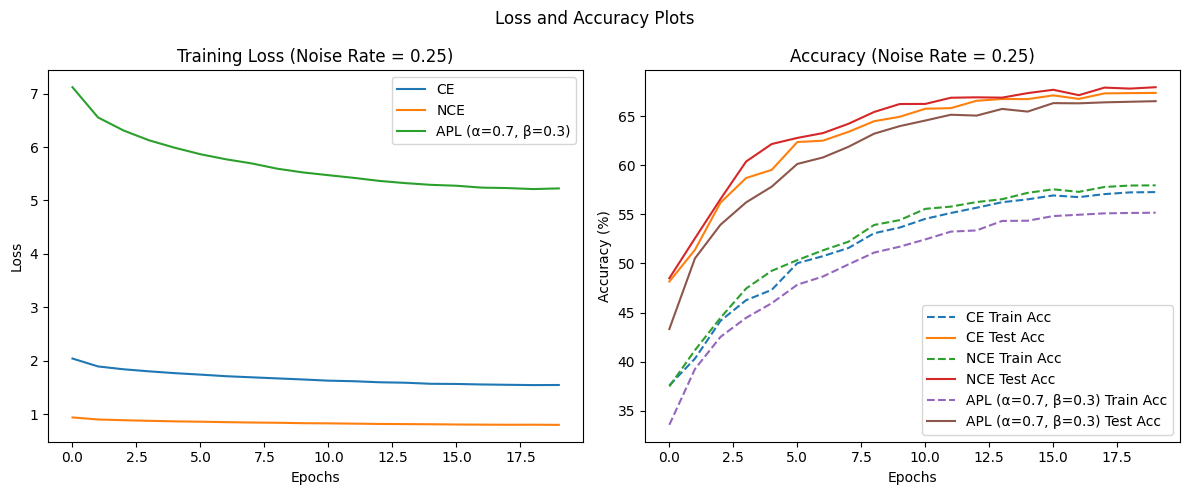


Training with noise rate = 0.5
  >> Training with CE
  >> Training with NCE
  >> Training with APL (α=0.5, β=0.5)


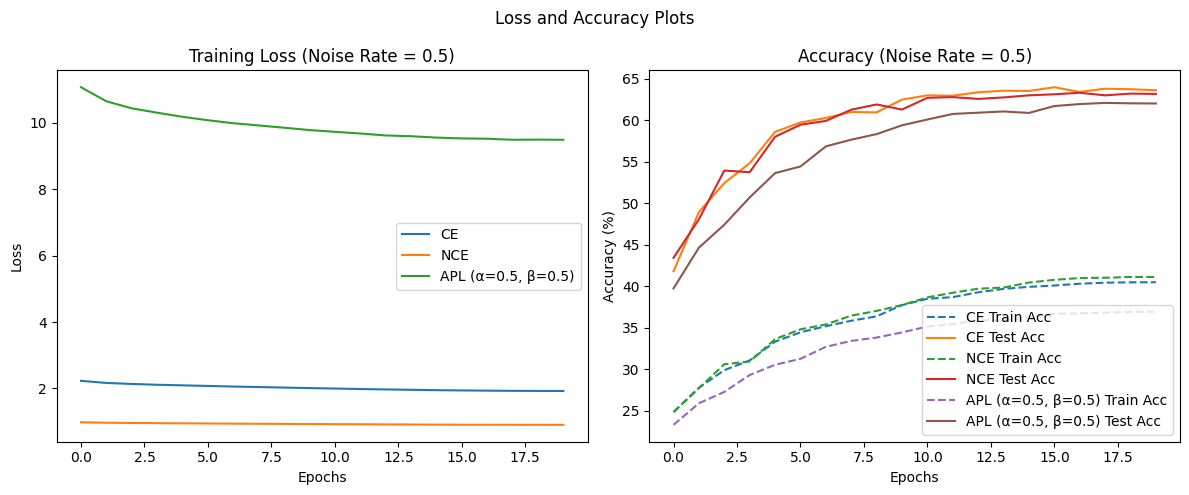


Training with noise rate = 0.75
  >> Training with CE
  >> Training with NCE
  >> Training with APL (α=0.3, β=0.7)


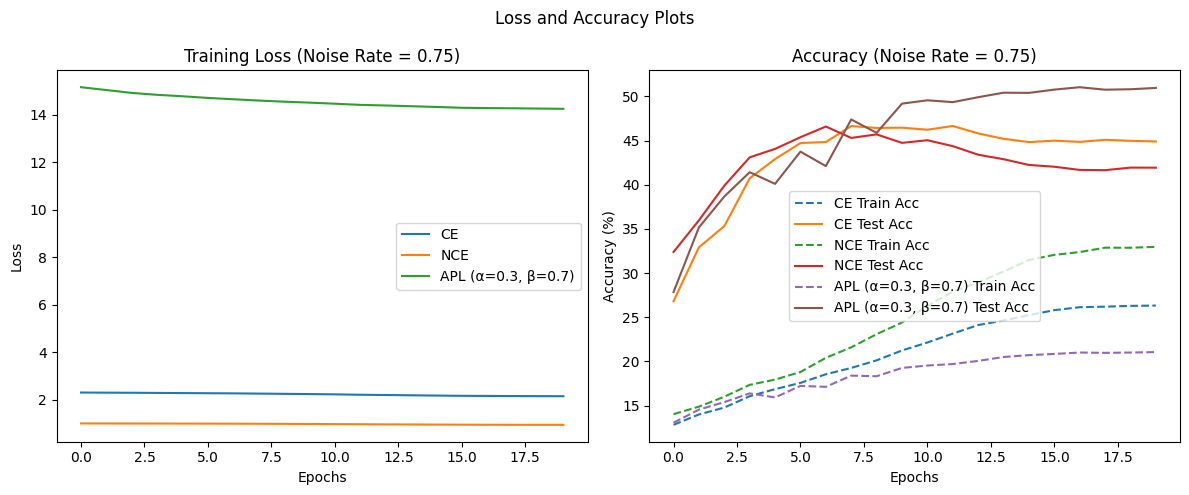

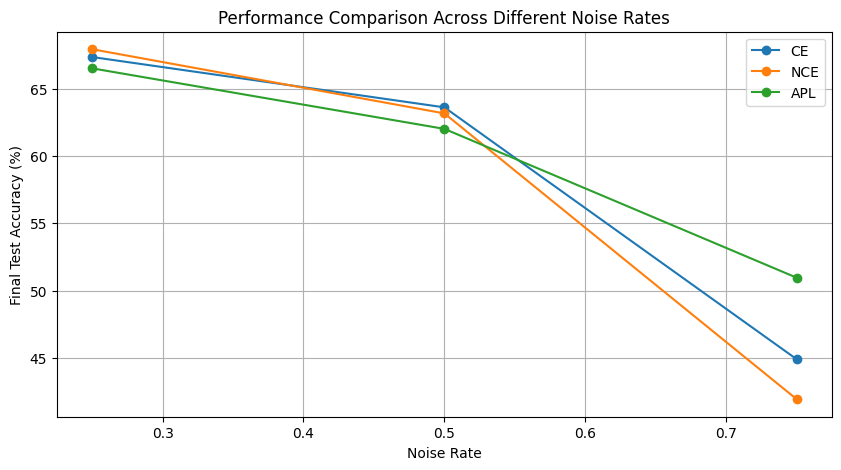

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset
import numpy as np
import random
import matplotlib.pyplot as plt

# === Loss functions ===

class FocalLoss(nn.Module):
    def __init__(self, gamma=2.0, alpha=1.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        self.reduction = reduction

    def forward(self, inputs, targets):
        logp = F.log_softmax(inputs, dim=1)
        p = torch.exp(logp)
        logp = logp.gather(1, targets.unsqueeze(1)).squeeze(1)
        p = p.gather(1, targets.unsqueeze(1)).squeeze(1)
        loss = -self.alpha * ((1 - p) ** self.gamma) * logp
        return loss.mean() if self.reduction == 'mean' else loss.sum()

class NormalizedCrossEntropy(nn.Module):
    def __init__(self):
        super(NormalizedCrossEntropy, self).__init__()

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        log_probs = torch.log(probs + 1e-10)
        loss = -log_probs[range(len(targets)), targets]
        normalizer = -torch.sum(probs * log_probs, dim=1)
        return (loss / (normalizer + 1e-10)).mean()

class NormalizedFocalLoss(nn.Module):
    def __init__(self, gamma=2.0):
        super(NormalizedFocalLoss, self).__init__()
        self.gamma = gamma

    def forward(self, logits, targets):
        probs = F.softmax(logits, dim=1)
        log_probs = torch.log(probs + 1e-10)
        pt = probs[range(len(targets)), targets]
        log_pt = log_probs[range(len(targets)), targets]
        loss = -(1 - pt) ** self.gamma * log_pt
        normalizer = -torch.sum(probs * log_probs, dim=1)
        return (loss / (normalizer + 1e-10)).mean()

class ReverseCrossEntropy(nn.Module):
    def __init__(self):
        super(ReverseCrossEntropy, self).__init__()

    def forward(self, logits, targets):
        targets_one_hot = F.one_hot(targets, num_classes=logits.size(1)).float().to(logits.device)
        probs = F.softmax(logits, dim=1)
        log_targets = torch.log(targets_one_hot + 1e-10)
        loss = -torch.sum(probs * log_targets, dim=1)
        return loss.mean()

class ActivePassiveLoss(nn.Module):
    def __init__(self, active_loss, passive_loss, alpha=0.5):
        super(ActivePassiveLoss, self).__init__()
        self.active_loss = active_loss
        self.passive_loss = passive_loss
        self.alpha = alpha

    def forward(self, logits, targets):
        loss_active = self.active_loss(logits, targets)
        loss_passive = self.passive_loss(logits, targets)
        return self.alpha * loss_active + (1 - self.alpha) * loss_passive

# === Dataset with noise ===

class NoisyCIFAR10(Dataset):
    def __init__(self, dataset, noise_rate=0.4, asymmetric=False):
        self.data = dataset.data
        self.targets = np.array(dataset.targets)
        self.transform = dataset.transform
        self.noise_rate = noise_rate
        self.noisy_labels = self.apply_noise(self.targets, noise_rate, asymmetric)

    def apply_noise(self, labels, noise_rate, asymmetric):
        noisy_labels = labels.copy()
        for c in np.unique(labels):
            class_idx = np.where(labels == c)[0]
            noisy_idx = np.random.choice(class_idx, int(noise_rate * len(class_idx)), replace=False)
            for i in noisy_idx:
                if asymmetric:
                    noisy_labels[i] = (c + 1) % 10
                else:
                    noisy_labels[i] = random.choice([x for x in range(10) if x != c])
        return noisy_labels

    def __getitem__(self, idx):
        img, label = self.data[idx], self.noisy_labels[idx]
        img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.data)

# === CNN Model ===

class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(64 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        return self.fc2(x)

# === Evaluation ===

def evaluate(model, dataloader):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    from sklearn.metrics import accuracy_score
    return accuracy_score(all_labels, all_preds)

# === Experiment Setup ===

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor()])
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(cifar_test, batch_size=128, shuffle=False)

noise_rates = [0.25, 0.5, 0.75]
num_epochs = 20

# Normalized alpha/beta for APL
apl_weights = {
    0.25: (0.7, 0.3),
    0.5: (0.5, 0.5),
    0.75: (0.3, 0.7)
}

final_accuracies = {'CE': [], 'NCE': [], 'APL': []}

for noise_rate in noise_rates:
    print(f"\nTraining with noise rate = {noise_rate}")
    alpha, beta = apl_weights[noise_rate]

    trainset = NoisyCIFAR10(cifar_train, noise_rate=noise_rate, asymmetric=False)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)

    loss_configs = {
        'CE': nn.CrossEntropyLoss(),
        'NCE': NormalizedCrossEntropy(),
        f'APL (α={alpha}, β={beta})': ActivePassiveLoss(nn.CrossEntropyLoss(), ReverseCrossEntropy(), alpha=alpha),
    }

    epoch_logs = {}

    for loss_name, loss_fn in loss_configs.items():
        print(f"  >> Training with {loss_name}")
        model = CNN().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

        train_loss_log, train_acc_log, test_acc_log = [], [], []

        for epoch in range(num_epochs):
            model.train()
            total_loss = 0.0

            with torch.enable_grad():
                for images, labels in trainloader:
                    images, labels = images.to(device), labels.to(device)
                    optimizer.zero_grad()
                    outputs = model(images)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item() * images.size(0)

            avg_loss = total_loss / len(trainloader.dataset)
            train_acc = evaluate(model, trainloader)
            test_acc = evaluate(model, testloader)

            train_loss_log.append(avg_loss)
            train_acc_log.append(train_acc * 100)
            test_acc_log.append(test_acc * 100)

            scheduler.step()

        epoch_logs[loss_name] = {
            'train_loss': train_loss_log,
            'train_acc': train_acc_log,
            'test_acc': test_acc_log,
        }

        if loss_name == 'CE':
            final_accuracies['CE'].append(test_acc_log[-1])
        elif loss_name == 'NCE':
            final_accuracies['NCE'].append(test_acc_log[-1])
        else:  # It's APL
            final_accuracies['APL'].append(test_acc_log[-1])

    # === Plot per-noise-rate Loss & Accuracy ===
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for loss_name in epoch_logs:
        plt.plot(epoch_logs[loss_name]['train_loss'], label=f"{loss_name}")
    plt.title(f"Training Loss (Noise Rate = {noise_rate})")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    for loss_name in epoch_logs:
        plt.plot(epoch_logs[loss_name]['train_acc'], label=f"{loss_name} Train Acc", linestyle='--')
        plt.plot(epoch_logs[loss_name]['test_acc'], label=f"{loss_name} Test Acc")
    plt.title(f"Accuracy (Noise Rate = {noise_rate})")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy (%)")
    plt.legend()

    plt.suptitle("Loss and Accuracy Plots")
    plt.tight_layout()
    plt.show()

# === Final Comparison Plot ===
plt.figure(figsize=(10, 5))
for loss_name, accs in final_accuracies.items():
    plt.plot(noise_rates[:len(accs)], accs, marker='o', label=loss_name)
plt.title("Performance Comparison Across Different Noise Rates")
plt.xlabel("Noise Rate")
plt.ylabel("Final Test Accuracy (%)")
plt.legend()
plt.grid(True)
plt.show()


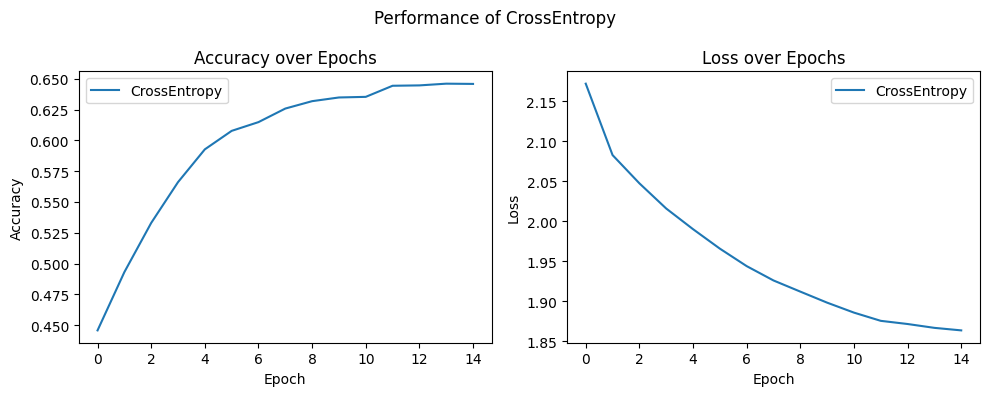

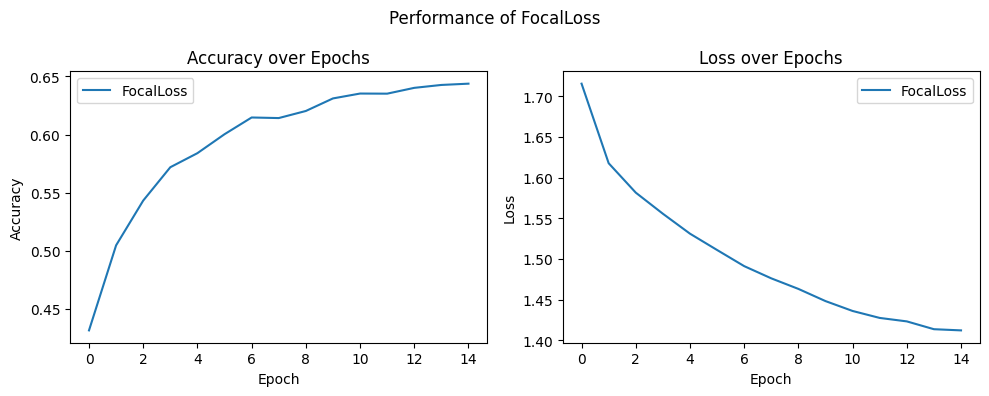

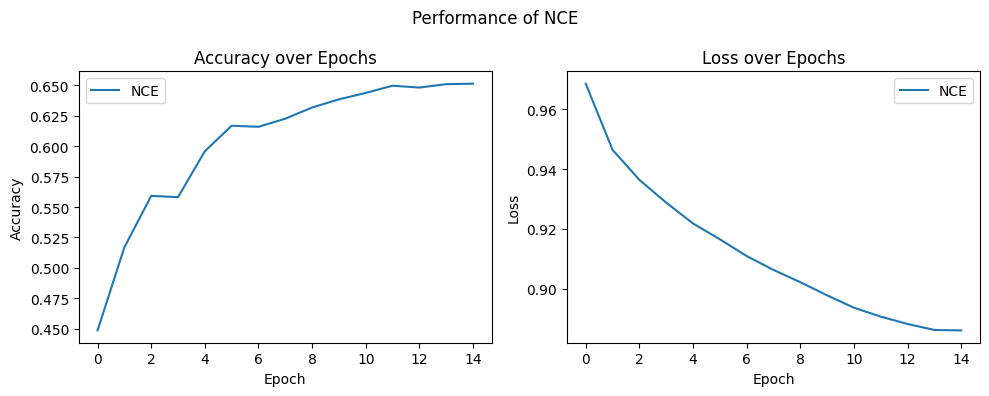

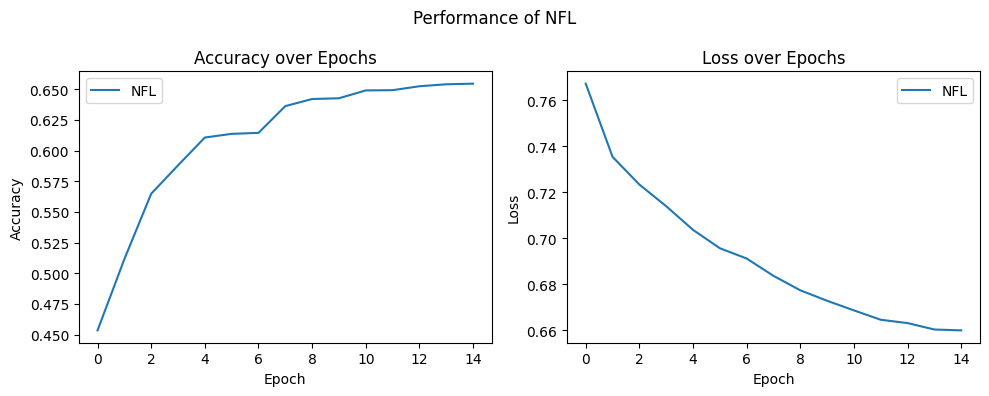

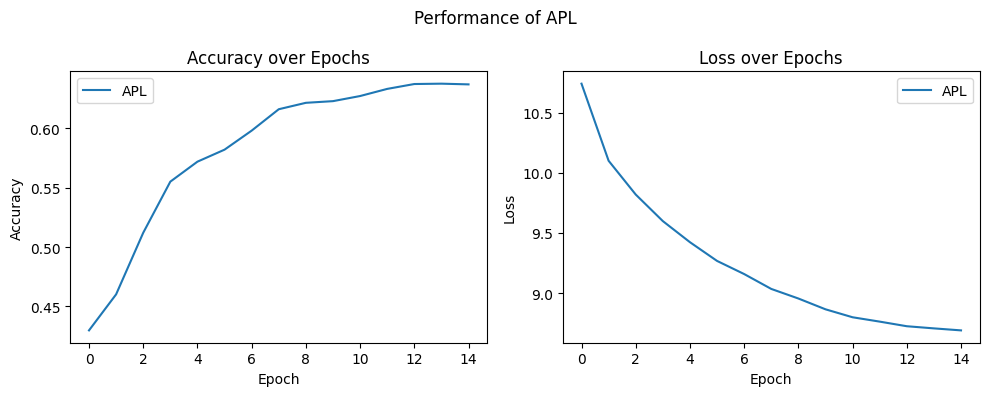

In [17]:
transform = transforms.Compose([transforms.ToTensor()])
cifar_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
cifar_test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainset = NoisyCIFAR10(cifar_train, noise_rate=0.4, asymmetric=False)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True)
testloader = torch.utils.data.DataLoader(cifar_test, batch_size=128, shuffle=False)

losses = {
    'CrossEntropy': nn.CrossEntropyLoss(),
    'FocalLoss': FocalLoss(),
    'NCE': NormalizedCrossEntropy(),
    'NFL': NormalizedFocalLoss(),
    'APL': ActivePassiveLoss(nn.CrossEntropyLoss(), ReverseCrossEntropy())
}
#run if errors:

'''print("\nRunning sanity check on all loss functions...\n")
model = CNN().to(device)
model.train()
dummy_input = torch.randn(4, 3, 32, 32).to(device)
dummy_target = torch.randint(0, 10, (4,)).to(device)

for name, loss_fn in losses.items():
    try:
        with torch.enable_grad():
            print(f"Testing: {name}")
            output = model(dummy_input)
            print(f"  Output requires_grad: {output.requires_grad}, grad_fn: {output.grad_fn}")
            loss = loss_fn(output, dummy_target)
            print(f"  Loss requires_grad: {loss.requires_grad}, grad_fn: {loss.grad_fn}")
            loss.backward()
            print(f"  ✅ {name} passed.\n")
    except Exception as e:
        print(f"  ❌ {name} failed with error: {e}\n")'''


results = {}
num_epochs = 15
loss_history = {}

for name, loss_fn in losses.items():
    model = CNN().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    epoch_losses = []
    epoch_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        with torch.enable_grad():
            for images, labels in trainloader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = loss_fn(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item() * images.size(0)

        avg_loss = running_loss / len(trainloader.dataset)
        acc = evaluate(model, testloader)
        epoch_losses.append(avg_loss)
        epoch_accuracies.append(acc)
        scheduler.step()

    results[name] = epoch_accuracies[-1]
    loss_history[name] = (epoch_losses, epoch_accuracies)

for name in loss_history:
    losses_list, accuracies = loss_history[name]

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(accuracies, label=name)
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(losses_list, label=name)
    plt.title("Loss over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.suptitle(f"Performance of {name}")
    plt.tight_layout()
    plt.show()

# **DIFFUSION**

# ***Part 1:***




In [ ]:
image_size = 256 #@param [256, 512]
vae_model = "stabilityai/sd-vae-ft-ema" #@param ["stabilityai/sd-vae-ft-mse", "stabilityai/sd-vae-ft-ema"]
latent_size = int(image_size) // 8
# Load model:
model = DiT_XL_2(input_size=latent_size).to(device)
state_dict = find_model(f"DiT-XL-2-{image_size}x{image_size}.pt")
model.load_state_dict(state_dict)
model.eval() # important!
vae = AutoencoderKL.from_pretrained(vae_model).to(device)

In [ ]:
# Set user inputs:
seed = 0 #@param {type:"number"}
torch.manual_seed(seed)
num_sampling_steps = 13 #@param {type:"slider", min:0, max:1000, step:1}
cfg_scale = 5 #@param {type:"slider", min:1, max:10, step:0.1}
class_labels = [89] #@param {type:"raw"}
samples_per_row = 50 #@param {type:"number"}

# Create diffusion object:
diffusion = create_diffusion(str(num_sampling_steps))

# Create sampling noise:
n = len(class_labels)
z = torch.randn(n, 4, latent_size, latent_size, device=device)
y = torch.tensor(class_labels, device=device)

# Setup classifier-free guidance:
z = torch.cat([z, z], 0)
y_null = torch.tensor([1000] * n, device=device)
y = torch.cat([y, y_null], 0)
model_kwargs = dict(y=y, cfg_scale=cfg_scale)

# Sample images:
samples = diffusion.p_sample_loop(
    model.forward_with_cfg, z.shape, z, clip_denoised=False,
    model_kwargs=model_kwargs, progress=True, device=device
)
samples, _ = samples.chunk(2, dim=0)  # Remove null class samples
samples = vae.decode(samples / 0.18215).sample

# Save and display images:
save_image(samples, "sample.png", nrow=int(samples_per_row),
           normalize=True, value_range=(-1, 1))
samples = Image.open("sample.png")
display(samples)


**At low values of cfg** : Weaker guidance, meaning the model doesn’t strongly enforce the class label.  images may be more diverse, creative, or even a bit off-label. *underfitting-looking results*


**At high values of cfg** : Very strong guidance: the model strictly follows the class conditioning. *overfitting-looking results*

**At Low Sample Steps :** Image appear blurry due to noise not being removed entirely due to low number of denoising steps. Output is fast

**At High Sample Steps :** Image appear Very detailed and crisp due to noise being completely removed. Output is very slow and there is diminished returns past a point.

# ***Part 2:***

# i:

In [ ]:
#Important Libraries:
!pip install xformers --upgrade
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Mlp
from abc import ABCMeta, abstractmethod
from dataclasses import asdict, dataclass
from typing import Optional, Type, TypeVar

from xformers._deprecation_warning import deprecated_function
from xformers.components.attention import AttentionMask
from xformers.components.attention import build_attention
from xformers.ops import memory_efficient_attention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import math
import matplotlib.pyplot as plt

# === Efficient Attention ===
try:
    from flash_attn import flash_attn_func
    def memory_efficient_attention(q, k, v):
        return flash_attn_func(q, k, v, dropout_p=0.0, causal=False)
except ImportError:
    try:
        import xformers.ops
        def memory_efficient_attention(q, k, v):
            return xformers.ops.memory_efficient_attention(q, k, v)
    except ImportError:
        def memory_efficient_attention(q, k, v):
            attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(q.size(-1))
            attn_probs = F.softmax(attn_scores, dim=-1)
            return torch.matmul(attn_probs, v)

# === Modulated LayerNorm ===
def modulated_layernorm(x, shift, scale, eps=1e-6):
    mean = x.mean(-1, keepdim=True)
    var = x.var(-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / torch.sqrt(var + eps)
    return norm_x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

# === Fused MLP ===
class FusedMlp(nn.Module):
    def __init__(self, in_features, hidden_features):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = nn.SiLU()
        self.fc2 = nn.Linear(hidden_features, in_features)

    def forward(self, x):
        return self.fc2(self.act(self.fc1(x)))

# === Optimized DiT Block ===
class FastDiTBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = hidden_size // num_heads
        self.qkv = nn.Linear(hidden_size, hidden_size * 3, bias=False)
        self.mlp = FusedMlp(hidden_size, int(hidden_size * mlp_ratio))
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        B, N, D = x.shape
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)

        x_msa = modulated_layernorm(x, shift_msa, scale_msa)
        qkv = self.qkv(x_msa).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn_out = memory_efficient_attention(q, k, v).transpose(1, 2).reshape(B, N, D)

        x = x + gate_msa.unsqueeze(1) * attn_out
        x_mlp = modulated_layernorm(x, shift_mlp, scale_mlp)
        x = x + gate_mlp.unsqueeze(1) * self.mlp(x_mlp)

        return x

# === Dummy Model with DiT Blocks ===
class DummyDiT(nn.Module):
    def __init__(self, hidden_size=768, num_heads=12, depth=12):
        super().__init__()
        self.blocks = nn.ModuleList([FastDiTBlock(hidden_size, num_heads) for _ in range(depth)])

    def forward(self, x, c):
        for block in self.blocks:
            x = block(x, c)
        return x

# === Benchmarking ===
def benchmark_model(model, batch_sizes, num_tokens=256, hidden_size=768, steps=50):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device).eval()
    model = model.to(memory_format=torch.channels_last)

    times = []
    for bs in batch_sizes:
        x = torch.randn(bs, num_tokens, hidden_size, device=device)
        c = torch.randn(bs, hidden_size, device=device)

        torch.cuda.synchronize()
        start = time.time()
        with torch.no_grad():
            for _ in range(steps):
                _ = model(x, c)
        torch.cuda.synchronize()
        elapsed = time.time() - start
        print(f"Batch size {bs}: {elapsed:.2f}s for {steps} steps")
        times.append(elapsed)
    return times

# === Plotting ===
def plot_batch_timing(batch_sizes, times, title="Sampling Time vs Batch Size"):
    plt.figure(figsize=(8, 5))
    plt.plot(batch_sizes, times, marker='o')
    plt.title(title)
    plt.xlabel("Batch Size")
    plt.ylabel("Time (s) for 50 Iterations")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Run It ===
batch_sizes = [50, 100, 150, 200, 250]
model = DummyDiT()
times = benchmark_model(model, batch_sizes)
plot_batch_timing(batch_sizes, times)


In [ ]:
# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# GLIDE: https://github.com/openai/glide-text2im
# MAE: https://github.com/facebookresearch/mae/blob/main/models_mae.py
# --------------------------------------------------------

import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp


def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


#################################################################################
#               Embedding Layers for Timesteps and Class Labels                 #
#################################################################################

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


#################################################################################
#                                 Core DiT Model                                #
#################################################################################

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x


class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1000,
        learn_sigma=True,
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        y = self.y_embedder(y, self.training)    # (N, D)
        c = t + y                                # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)


#################################################################################
#                   Sine/Cosine Positional Embedding Functions                  #
#################################################################################
# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb


#################################################################################
#                                   DiT Configs                                  #
#################################################################################

def DiT_XL_2(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=2, num_heads=16, **kwargs)

def DiT_XL_4(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=4, num_heads=16, **kwargs)

def DiT_XL_8(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=8, num_heads=16, **kwargs)

def DiT_L_2(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=2, num_heads=16, **kwargs)

def DiT_L_4(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=4, num_heads=16, **kwargs)

def DiT_L_8(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=8, num_heads=16, **kwargs)

def DiT_B_2(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=2, num_heads=12, **kwargs)

def DiT_B_4(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=4, num_heads=12, **kwargs)

def DiT_B_8(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=8, num_heads=12, **kwargs)

def DiT_S_2(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=2, num_heads=6, **kwargs)

def DiT_S_4(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=4, num_heads=6, **kwargs)

def DiT_S_8(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=8, num_heads=6, **kwargs)


DiT_models = {
    'DiT-XL/2': DiT_XL_2,  'DiT-XL/4': DiT_XL_4,  'DiT-XL/8': DiT_XL_8,
    'DiT-L/2':  DiT_L_2,   'DiT-L/4':  DiT_L_4,   'DiT-L/8':  DiT_L_8,
    'DiT-B/2':  DiT_B_2,   'DiT-B/4':  DiT_B_4,   'DiT-B/8':  DiT_B_8,
    'DiT-S/2':  DiT_S_2,   'DiT-S/4':  DiT_S_4,   'DiT-S/8':  DiT_S_8,
}

def plot_batch_timing(batch_sizes, times, title="Sampling Time vs Batch Size"):
    plt.figure(figsize=(8, 5))
    plt.plot(batch_sizes, times, marker='o', linestyle='-')
    plt.xlabel("Batch Size")
    plt.ylabel("Time to Sample 50 Images (s)")
    plt.title(title)
    plt.grid(True)
    plt.xticks(batch_sizes)
    plt.tight_layout()
    plt.show()

batch_sizes = [50, 100, 150, 200, 250]
times = []

print(type(model.blocks[0].attn))

for bs in batch_sizes:
    x = torch.randn(bs, 4, 32, 32).to(device)
    t = torch.randint(0, 1000, (bs,), device=device)
    y = torch.randint(0, 1000, (bs,), device=device)

    start = time.time()
    with torch.no_grad():
        for _ in range(50):
            _ = model(x, t, y)
    end = time.time()

    elapsed = end - start
    print(f" Sampled 50 images with batch size {bs} in {elapsed:.2f} seconds")
    times.append(elapsed)

plot_batch_timing(batch_sizes, times)

**Fix 1:** Added Memory effecient attention.

# ii:

In [ ]:
import os

for root, dirs, files in os.walk("/content"):
    if "models.py" in files:
        print("Found models.py at:", os.path.join(root, "models.py"))

import kagglehub

path = kagglehub.dataset_download("arnaud58/landscape-pictures")

print("Path to dataset files:", path)

!pip install torch torchvision timm accelerate einops scipy ftfy
!pip install torchmetrics
!git clone https://github.com/facebookresearch/DiT.git
%cd DiT

!pip install torch torchvision timm accelerate einops scipy ftfy torchmetrics

import sys
sys.path.append('.')

from models import DiT_B_8

#loading data set
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import shutil

new_root = '/content/landscape_dataset/images'


os.makedirs(new_root, exist_ok=True)

for file in os.listdir(path):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        src = os.path.join(path, file)
        dst = os.path.join(new_root, file)
        shutil.copy(src, dst)

dataset_root = '/content/landscape_dataset'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) ])

dataset = datasets.ImageFolder(root=dataset_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

real_img, _ = next(iter(dataloader))

In [ ]:
#cloning DiT repo


!pip install torch torchvision timm accelerate einops scipy ftfy
!pip install torchmetrics
!git clone https://github.com/facebookresearch/DiT.git
%cd DiT

!pip install torch torchvision timm accelerate einops scipy ftfy torchmetrics

import sys
sys.path.append('.')

from models import DiT_B_8

In [ ]:
#loading data set
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import shutil

new_root = '/content/landscape_dataset/images'


os.makedirs(new_root, exist_ok=True)

for file in os.listdir(path):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        src = os.path.join(path, file)
        dst = os.path.join(new_root, file)
        shutil.copy(src, dst)

dataset_root = '/content/landscape_dataset'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) ])

dataset = datasets.ImageFolder(root=dataset_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

real_img, _ = next(iter(dataloader))

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp
import torch.optim as optim
import torch.nn as nn
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import shutil
from torch.optim.swa_utils import AveragedModel, update_bn


new_root = '/content/landscape_dataset/images'


os.makedirs(new_root, exist_ok=True)

for file in os.listdir(path):
    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
        src = os.path.join(path, file)
        dst = os.path.join(new_root, file)
        shutil.copy(src, dst)

dataset_root = '/content/landscape_dataset'

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3) ])

dataset = datasets.ImageFolder(root=dataset_root, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

real_img, _ = next(iter(dataloader))
fake_channel = torch.zeros((real_img.shape[0], 1, 256, 256))
real_img_4ch = torch.cat([real_img, fake_channel], dim=1)

def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)


class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """
    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb


class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """
    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings


#################################################################################
#                                 Core DiT Model                                #
#################################################################################
class SlidingWindowAttention(nn.Module):
    def __init__(self, dim, num_heads=8, window_size=5, qkv_bias=True):
        super().__init__()
        self.num_heads = num_heads
        self.window_size = window_size
        self.scale = (dim // num_heads) ** -0.5
        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads)
        q, k, v = qkv.permute(2, 0, 3, 1, 4)  # (3, B, num_heads, N, dim)

        attn_scores = torch.zeros(B, self.num_heads, N, N, device=x.device)

        for i in range(N):
            start = max(0, i - self.window_size)
            end = min(N, i + self.window_size + 1)
            qi = q[:, :, i:i+1, :]  # (B, heads, 1, dim)
            ki = k[:, :, start:end, :]  # (B, heads, W, dim)
            attn_scores[:, :, i:i+1, start:end] = (qi @ ki.transpose(-2, -1)) * self.scale

        attn = attn_scores.softmax(dim=-1)
        out = attn @ v
        out = out.transpose(1, 2).reshape(B, N, C)
        return self.proj(out)

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """
    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        if block_kwargs.get("use_swa", False):
          self.attn = SlidingWindowAttention(hidden_size, num_heads=num_heads, window_size=block_kwargs.get("window_size", 5))
        else:
          self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True)

        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 6 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(6, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x


class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """
    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x


class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """
    def __init__(
        self,
        input_size=32,
        patch_size=2,
        in_channels=4,
        hidden_size=1152,
        depth=28,
        num_heads=16,
        mlp_ratio=4.0,
        class_dropout_prob=0.1,
        num_classes=1000,
        learn_sigma=True,
        use_swa=False,
        window_size=5
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        num_patches = self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio,use_swa=use_swa, window_size=window_size) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.x_embedder.num_patches ** 0.5))
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        w = self.x_embedder.proj.weight.data
        nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D)  T = H * W / patch_size ** 2
        t = self.t_embedder(t)                   # (N, D)
        y = torch.zeros_like(t)
    # (N, D)
        c = t + y                                # (N, D)
        for block in self.blocks:
            x = block(x, c)                      # (N, T, D)
        x = self.final_layer(x, c)                # (N, T, patch_size ** 2 * out_channels)
        x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        model_out = self.forward(combined, t, y)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        # eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)


#################################################################################
#                   Sine/Cosine Positional Embedding Functions                  #
#################################################################################
# https://github.com/facebookresearch/mae/blob/main/util/pos_embed.py

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed


def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = np.concatenate([emb_h, emb_w], axis=1) # (H*W, D)
    return emb


def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def plot_output_comparison(out_full, out_swa, title1="Full Attention", title2="SWA"):
    import matplotlib.pyplot as plt
    from torchvision.utils import make_grid

    def img_tensor_to_numpy(img):
        img = (img.clamp(-1, 1) + 1) / 2
        img = make_grid(img[:, :3], nrow=1).permute(1, 2, 0).cpu().detach().numpy()
        return img

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img_tensor_to_numpy(out_full))
    axs[0].set_title(title1)
    axs[0].axis("off")
    axs[1].imshow(img_tensor_to_numpy(out_swa))
    axs[1].set_title(title2)
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()
#################################################################################
#                                   DiT Configs                                  #
#################################################################################

def DiT_XL_2(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=2, num_heads=16, **kwargs)

def DiT_XL_4(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=4, num_heads=16, **kwargs)

def DiT_XL_8(**kwargs):
    return DiT(depth=28, hidden_size=1152, patch_size=8, num_heads=16, **kwargs)

def DiT_L_2(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=2, num_heads=16, **kwargs)

def DiT_L_4(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=4, num_heads=16, **kwargs)

def DiT_L_8(**kwargs):
    return DiT(depth=24, hidden_size=1024, patch_size=8, num_heads=16, **kwargs)

def DiT_B_2(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=2, num_heads=12, **kwargs)

def DiT_B_4(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=4, num_heads=12, **kwargs)

def DiT_B_8(**kwargs):
    return DiT(depth=12, hidden_size=768, patch_size=8, num_heads=12, **kwargs)

def DiT_S_2(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=2, num_heads=6, **kwargs)

def DiT_S_4(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=4, num_heads=6, **kwargs)

def DiT_S_8(**kwargs):
    return DiT(depth=12, hidden_size=384, patch_size=8, num_heads=6, **kwargs)


DiT_models = {
    'DiT-XL/2': DiT_XL_2,  'DiT-XL/4': DiT_XL_4,  'DiT-XL/8': DiT_XL_8,
    'DiT-L/2':  DiT_L_2,   'DiT-L/4':  DiT_L_4,   'DiT-L/8':  DiT_L_8,
    'DiT-B/2':  DiT_B_2,   'DiT-B/4':  DiT_B_4,   'DiT-B/8':  DiT_B_8,
    'DiT-S/2':  DiT_S_2,   'DiT-S/4':  DiT_S_4,   'DiT-S/8':  DiT_S_8,
}


device = "cuda" if torch.cuda.is_available() else "cpu"


model_full = DiT_B_8(input_size=256, in_channels=4).to(device)
model_swa = AveragedModel(model_full).to(device)

real_img_4ch = real_img_4ch.to(device)
t = torch.tensor([1], dtype=torch.long, device=device)
y = torch.tensor([0], dtype=torch.long, device=device)

with torch.no_grad():
    out_full = model_full(real_img_4ch, t, y)
    out_swa  = model_swa(real_img_4ch, t, y)

real_img_4ch = real_img_4ch.to(device)
t = t.to(device)
y = y.to(device)
model_full = model_full.to(device)
model_swa = model_swa.to(device)

loss_fn = nn.MSELoss()
optimizer_full = optim.Adam(model_full.parameters(), lr=1e-4)
optimizer_swa  = optim.Adam(model_swa.parameters(),  lr=1e-4)

In [ ]:
!pip install torchmetrics[image]

from torchmetrics.image.fid import FrechetInceptionDistance
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt

In [ ]:
import torch
from torchmetrics.image.fid import FrechetInceptionDistance
import matplotlib.pyplot as plt


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

fid_full = FrechetInceptionDistance(feature=2048).to(device)
fid_swa = FrechetInceptionDistance(feature=2048).to(device)

def denormalize_to_uint8(tensor):
    tensor = (tensor * 0.5 + 0.5).clamp(0, 1)
    return (tensor * 255).to(torch.uint8)

fid_scores_full = []
fid_scores_swa = []

num_epochs = 20
swa_start = 4

for epoch in range(num_epochs):
    model_full.train()

    for i, (real_img, _) in enumerate(dataloader):
        if i >= 50: break

        real_img = real_img.to(device)
        fake_channel = torch.zeros((real_img.size(0), 1, 256, 256), device=device)
        real_img_4ch = torch.cat([real_img, fake_channel], dim=1)

        t = torch.randint(0, 1000, (real_img.size(0),), device=device)
        y = torch.zeros(real_img.size(0), dtype=torch.long, device=device)

        optimizer_full.zero_grad()
        out_full = model_full(real_img_4ch, t, y)
        loss_full = loss_fn(out_full[:, :3], real_img)
        loss_full.backward()
        optimizer_full.step()

        if i % 10 == 0:
            print(f"Epoch {epoch+1}, Step {i}, Full Loss: {loss_full.item():.4f}")


    if epoch >= swa_start:
        model_swa.update_parameters(model_full)


    model_full.eval()
    model_swa.eval()
    fid_full.reset()
    fid_swa.reset()

    if epoch >= swa_start:
        update_bn(dataloader, model_swa)

    real_imgs = []
    for real_img, _ in dataloader:
        real_img = real_img.to(device)
        real_imgs.append(real_img)
        real_img_uint8 = denormalize_to_uint8(real_img).to(device)
        fid_full.update(real_img_uint8, real=True)
        if epoch >= swa_start:
            fid_swa.update(real_img_uint8, real=True)
        if len(real_imgs) >= 50:
            break

    with torch.no_grad():
        for img in real_imgs:
            B = img.shape[0]
            z = torch.zeros((B, 1, 256, 256), device=device)
            x = torch.cat([img, z], dim=1)
            t = torch.randint(0, 1000, (B,), device=device)
            y = torch.zeros(B, dtype=torch.long, device=device)

            fake_full = model_full(x, t, y)
            fake_full_uint8 = denormalize_to_uint8(fake_full[:, :3]).to(device)
            fid_full.update(fake_full_uint8, real=False)

            if epoch >= swa_start:
                fake_swa = model_swa(x, t, y)
                fake_swa_uint8 = denormalize_to_uint8(fake_swa[:, :3]).to(device)
                fid_swa.update(fake_swa_uint8, real=False)

    score_full = fid_full.compute().item()
    score_swa = fid_swa.compute().item() if epoch >= swa_start else float('nan')

    fid_scores_full.append(score_full)
    fid_scores_swa.append(score_swa)

    print(f"\nEpoch {epoch+1}: FID (Full) = {score_full:.2f}", end='')
    if epoch >= swa_start:
        print(f", FID (SWA) = {score_swa:.2f}\n")
    else:
        print(", FID (SWA) = N/A (not started)\n")


    if epoch >= swa_start:
        plot_output_comparison(fake_full, fake_swa)
    else:
        plot_output_comparison(fake_full, fake_full)

epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(8, 5))
plt.plot(epochs, fid_scores_full, label='Full Attention', marker='o')
plt.plot(epochs, fid_scores_swa, label='SWA', marker='s')
plt.xlabel("Epoch")
plt.ylabel("FID Score (lower is better)")
plt.title("FID Score vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# ***Part 3:***

# i:

*All Diffusion Part 2 Cells must be run first*

In [ ]:

!pip install git+https://github.com/openai/CLIP.git

import clip
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize, ToPILImage
from torchmetrics.image.fid import FrechetInceptionDistance


device = "cuda" if torch.cuda.is_available() else "cpu"

model_clip, preprocess = clip.load("ViT-B/32", device=device)

def get_clip_features(images):
    image_inputs = torch.stack([preprocess(img) for img in images]).to(device)
    with torch.no_grad():
        features = model_clip.encode_image(image_inputs)
        features = features / features.norm(dim=-1, keepdim=True)
    return features

def gaussian_kernel(x, y, sigma=1.0):
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)
    dist = ((x - y) ** 2).sum(-1)
    return torch.exp(-dist / (2 * sigma ** 2))

def compute_mmd(x, y, sigma=1.0):
    K_xx = gaussian_kernel(x, x, sigma).mean()
    K_yy = gaussian_kernel(y, y, sigma).mean()
    K_xy = gaussian_kernel(x, y, sigma).mean()
    return K_xx + K_yy - 2 * K_xy

def compute_cmmd(real_images, gen_images, sigma=1.0):
    real_feats = get_clip_features(real_images)
    gen_feats = get_clip_features(gen_images)
    mmd_score = compute_mmd(real_feats, gen_feats, sigma)
    return mmd_score.item()

def denormalize_to_uint8(tensor):
    tensor = (tensor * 0.5 + 0.5).clamp(0, 1)
    return (tensor * 255).to(torch.uint8)

def smooth_curve(values, window=3):
    return np.convolve(values, np.ones(window)/window, mode='valid')


def train_model(model_full, model_swa, dataloader, update_bn, num_epochs=100, swa_start=10):
    loss_fn = torch.nn.MSELoss()
    optimizer_full = torch.optim.Adam(model_full.parameters(), lr=1e-4)
    optimizer_swa = torch.optim.Adam(model_swa.parameters(), lr=1e-4)
    to_pil = ToPILImage()

    fid_full = FrechetInceptionDistance(feature=2048).to(device)
    fid_swa = FrechetInceptionDistance(feature=2048).to(device)

    fid_scores_full = []
    fid_scores_swa = []
    cmmd_full_scores = []
    cmmd_swa_scores = []

    for epoch in range(num_epochs):
        model_full.train()
        for i, (real_img, _) in enumerate(dataloader):
            if i >= 50: break
            real_img = real_img.to(device)
            fake_channel = torch.zeros((real_img.size(0), 1, 256, 256), device=device)
            real_img_4ch = torch.cat([real_img, fake_channel], dim=1)

            t = torch.randint(0, 1000, (real_img.size(0),), device=device)
            y = torch.zeros(real_img.size(0), dtype=torch.long, device=device)

            optimizer_full.zero_grad()
            out_full = model_full(real_img_4ch, t, y)
            loss_full = loss_fn(out_full[:, :3], real_img)
            loss_full.backward()
            optimizer_full.step()

            if i % 10 == 0:
                print(f"Epoch {epoch+1}, Step {i}, Full Loss: {loss_full.item():.4f}")

        if epoch >= swa_start:
            model_swa.update_parameters(model_full)

        model_full.eval()
        model_swa.eval()
        fid_full.reset()
        fid_swa.reset()

        if epoch >= swa_start:
            update_bn(dataloader, model_swa)

        real_images = []
        for real_img, _ in dataloader:
            real_img = real_img.to(device)
            real_imgs_uint8 = denormalize_to_uint8(real_img).to(device)
            fid_full.update(real_imgs_uint8, real=True)
            if epoch >= swa_start:
                fid_swa.update(real_imgs_uint8, real=True)

            for i in range(real_img.size(0)):
                real_images.append(to_pil(real_img[i].cpu().clamp(-1, 1)))

            if len(real_images) >= 100:
                break

        fake_full_pil = []
        fake_swa_pil = []

        with torch.no_grad():
            for _ in range(10):
                real_img_batch, _ = next(iter(dataloader))
                real_img_batch = real_img_batch.to(device)
                z = torch.zeros((real_img_batch.size(0), 1, 256, 256), device=device)
                x = torch.cat([real_img_batch, z], dim=1)
                t = torch.randint(0, 1000, (real_img_batch.size(0),), device=device)
                y = torch.zeros(real_img_batch.size(0), dtype=torch.long, device=device)

                fake_full = model_full(x, t, y)
                fake_full_uint8 = denormalize_to_uint8(fake_full[:, :3])
                fid_full.update(fake_full_uint8, real=False)

                for k in range(real_img_batch.size(0)):
                    fake_full_pil.append(to_pil(fake_full[k, :3].cpu().clamp(-1, 1)))

                if epoch >= swa_start:
                    fake_swa = model_swa(x, t, y)
                    fake_swa_uint8 = denormalize_to_uint8(fake_swa[:, :3])
                    fid_swa.update(fake_swa_uint8, real=False)

                    for k in range(real_img_batch.size(0)):
                        fake_swa_pil.append(to_pil(fake_swa[k, :3].cpu().clamp(-1, 1)))

        score_full = fid_full.compute().item()
        score_swa = fid_swa.compute().item() if epoch >= swa_start else float('nan')
        fid_scores_full.append(score_full)
        fid_scores_swa.append(score_swa)

        cmmd_full = compute_cmmd(real_images, fake_full_pil)
        cmmd_swa = compute_cmmd(real_images, fake_swa_pil) if epoch >= swa_start else float('nan')
        cmmd_full_scores.append(cmmd_full)
        cmmd_swa_scores.append(cmmd_swa)

        print(f"\nEpoch {epoch+1}: FID (Full) = {score_full:.2f}, FID (SWA) = {score_swa:.2f}")
        print(f"            CMMD (Full) = {cmmd_full:.4f}, CMMD (SWA) = {cmmd_swa:.4f}\n")


    epochs = list(range(1, num_epochs + 1))
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, fid_scores_full, label='FID Full Attention', marker='o')
    plt.plot(epochs, fid_scores_swa, label='FID SWA', marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("FID Score")
    plt.title("FID vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(10, 5))
    plt.plot(epochs, cmmd_full_scores, label='CMMD Full Attention', marker='o')
    plt.plot(epochs, cmmd_swa_scores, label='CMMD SWA', marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("CMMD Score")
    plt.title("CMMD vs Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

train_model(model_full, model_swa, dataloader, update_bn, num_epochs=20, swa_start=4)


# ii:

**SigLIP & ALIGN**

In [ ]:
!pip install torchmetrics[image]
!pip install torch-fidelity
!pip install transformers timm
!pip install git+https://github.com/openai/CLIP.git
import os
import math
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader
from torch import nn, optim
from torchmetrics.image.fid import FrechetInceptionDistance
from torch.optim.swa_utils import AveragedModel, update_bn
import clip
from transformers import SiglipProcessor, SiglipVisionModel, AutoProcessor, AutoModel

device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import torch
from torchvision.transforms import ToPILImage, Resize
import clip
from transformers import SiglipProcessor, SiglipVisionModel, AutoProcessor, AutoModel
import numpy as np
import matplotlib.pyplot as plt

# Image conversion
to_pil = ToPILImage()
resize_224 = Resize((224, 224))

# Device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load models
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
siglip_model = SiglipVisionModel.from_pretrained("google/siglip-base-patch16-224").to(device)
siglip_processor = SiglipProcessor.from_pretrained("google/siglip-base-patch16-224")
align_model = AutoModel.from_pretrained("kakaobrain/align-base").vision_model.to(device)
align_processor = AutoProcessor.from_pretrained("kakaobrain/align-base")

# Feature extraction
def get_clip_features(images):
    image_inputs = torch.stack([clip_preprocess(img) for img in images]).to(device)
    with torch.no_grad():
        features = clip_model.encode_image(image_inputs)
        return features / features.norm(dim=-1, keepdim=True)

def get_semantic_features(images, model, processor):
    pixel_values = processor(images=images, return_tensors="pt").pixel_values.to(device)
    with torch.no_grad():
        outputs = model(pixel_values)
        feats = outputs.last_hidden_state[:, 0, :]
        return feats / feats.norm(dim=-1, keepdim=True)

# CMMD tools
def gaussian_kernel(x, y, sigma=1.0):
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)
    dist = ((x - y) ** 2).sum(-1)
    return torch.exp(-dist / (2 * sigma ** 2))

def compute_mmd(x, y, sigma=1.0):
    return gaussian_kernel(x, x, sigma).mean() + \
           gaussian_kernel(y, y, sigma).mean() - \
           2 * gaussian_kernel(x, y, sigma).mean()

def compute_cmmd(real_images, gen_images, model=None, processor=None, is_clip=False):
    if is_clip:
        real_feats = get_clip_features(real_images)
        gen_feats = get_clip_features(gen_images)
    else:
        real_feats = get_semantic_features(real_images, model, processor)
        gen_feats = get_semantic_features(gen_images, model, processor)
    return compute_mmd(real_feats, gen_feats).item()

def smooth(data, weight=0.85):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point
        smoothed.append(smoothed_val)
        last = smoothed_val
    return smoothed

# Trackers
clip_cmmd_full, clip_cmmd_swa = [], []
siglip_cmmd_full, siglip_cmmd_swa = [], []
align_cmmd_full, align_cmmd_swa = [], []

num_epochs = 20
swa_start = 4
loss_fn = torch.nn.MSELoss()
optimizer_full = torch.optim.Adam(model_full.parameters(), lr=1e-4)
optimizer_swa = torch.optim.Adam(model_swa.parameters(), lr=1e-4)

# Training loop
for epoch in range(num_epochs):
    model_full.train()
    for i, (real_img, _) in enumerate(dataloader):
        if i >= 50: break
        real_img = real_img.to(device)
        fake_channel = torch.zeros((real_img.size(0), 1, 256, 256), device=device)
        real_img_4ch = torch.cat([real_img, fake_channel], dim=1)
        t = torch.randint(0, 1000, (real_img.size(0),), device=device)
        y = torch.zeros(real_img.size(0), dtype=torch.long, device=device)

        optimizer_full.zero_grad()
        out_full = model_full(real_img_4ch, t, y)
        loss_full = loss_fn(out_full[:, :3], real_img)
        loss_full.backward()
        optimizer_full.step()

    # SWA update
    if epoch >= swa_start:
        model_swa.update_parameters(model_full)
        update_bn(dataloader, model_swa)

    # Generate real/fake samples
    model_full.eval()
    model_swa.eval()

    real_images = []
    for real_img, _ in dataloader:
        real_img = real_img.to(device)
        for i in range(real_img.size(0)):
            real_images.append(to_pil(real_img[i].cpu().clamp(-1, 1)))
        if len(real_images) >= 100:
            break

    fake_full_pil, fake_swa_pil = [], []
    with torch.no_grad():
        for _ in range(10):
            real_img_batch, _ = next(iter(dataloader))
            real_img_batch = real_img_batch.to(device)
            z = torch.zeros((real_img_batch.size(0), 1, 256, 256), device=device)
            x = torch.cat([real_img_batch, z], dim=1)
            t = torch.randint(0, 1000, (real_img_batch.size(0),), device=device)
            y = torch.zeros(real_img_batch.size(0), dtype=torch.long, device=device)

            fake_full = model_full(x, t, y)
            for k in range(fake_full.size(0)):
                fake_full_pil.append(to_pil(fake_full[k, :3].cpu().clamp(-1, 1)))

            if epoch >= swa_start:
                fake_swa = model_swa(x, t, y)
                for k in range(fake_swa.size(0)):
                    fake_swa_pil.append(to_pil(fake_swa[k, :3].cpu().clamp(-1, 1)))

    # Compute CMMDs
    clip_full = compute_cmmd(real_images, fake_full_pil, is_clip=True)
    clip_swa = compute_cmmd(real_images, fake_swa_pil, is_clip=True) if epoch >= swa_start else float('nan')
    clip_cmmd_full.append(clip_full)
    clip_cmmd_swa.append(clip_swa)

    siglip_full = compute_cmmd(real_images, fake_full_pil, siglip_model, siglip_processor)
    siglip_swa = compute_cmmd(real_images, fake_swa_pil, siglip_model, siglip_processor) \
        if epoch >= swa_start else siglip_full
    siglip_cmmd_full.append(siglip_full)
    siglip_cmmd_swa.append(siglip_swa)

    align_full = compute_cmmd(real_images, fake_full_pil, align_model, align_processor)
    align_swa = compute_cmmd(real_images, fake_swa_pil, align_model, align_processor) \
        if epoch >= swa_start else align_full
    align_cmmd_full.append(align_full)
    align_cmmd_swa.append(align_swa)

    print(f"\nEpoch {epoch+1}:")
    print(f"CLIP   CMMD (Full): {clip_full:.4f}, CMMD (SWA): {clip_swa:.4f}")
    print(f"SIGLIP CMMD (Full): {siglip_full:.4f}, CMMD (SWA): {siglip_swa:.4f}")
    print(f"ALIGN  CMMD (Full): {align_full:.4f}, CMMD (SWA): {align_swa:.4f}\n")

# Plotting
epochs = list(range(num_epochs))

plt.figure(figsize=(8, 5))
plt.plot(epochs, smooth(siglip_cmmd_full), label='SIGLIP CMMD Full', color='green', marker='o')
plt.plot(epochs, smooth(siglip_cmmd_swa), label='SIGLIP CMMD SWA', color='lime', marker='s')
plt.xlabel("Epoch")
plt.ylabel("CMMD Score")
plt.title("SIGLIP CMMD vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(epochs, smooth(align_cmmd_full), label='ALIGN CMMD Full', color='purple', marker='o')
plt.plot(epochs, smooth(align_cmmd_swa), label='ALIGN CMMD SWA', color='magenta', marker='s')
plt.xlabel("Epoch")
plt.ylabel("CMMD Score")
plt.title("ALIGN CMMD vs Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
